In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import pandas as pd
import numpy as np
from pathlib import Path
from typing import *
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
import sys
sys.path.append("../lib")

In [4]:
from bert_utils import Config, BertPreprocessor

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [5]:
config = Config(
    model_type="bert-base-uncased",
    max_seq_len=128,
    subspace_size=5,
)

In [6]:
processor = BertPreprocessor(config.model_type, config.max_seq_len)

In [7]:
from pytorch_pretrained_bert import BertConfig, BertForMaskedLM
model = BertForMaskedLM.from_pretrained(config.model_type)
model.eval()

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediate): BertIntermediate(
       

In [8]:
from dataclasses import dataclass

@dataclass
class ContextWord:
    sent: str
    word: str
    def __post_init__(self):
        assert self.word in self.sent

In [9]:
def cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

In [10]:
def get_word_vector(cword: ContextWord, use_last_mask=False):
    sentence, word = cword.sent, cword.word
    idx = processor.get_index(sentence, word, last=use_last_mask)
    outputs = None
    with torch.no_grad():
        sequence_output, _ = model.bert(processor.to_bert_model_input(sentence),
                                        output_all_encoded_layers=False)
        sequence_output.squeeze_(0)
        if outputs is None: outputs = torch.zeros_like(sequence_output)
        outputs = sequence_output + outputs
    return outputs.detach().cpu().numpy()[idx]

In [11]:
def construct_sim_matrix(vecs):
    sim_matrix = np.zeros((len(vecs), len(vecs)))
    for i, v in enumerate(vecs):
        for j, w in enumerate(vecs):
            sim_matrix[i, j] = cosine_similarity(v, w)
    return sim_matrix

In [12]:
def construct_sim_matrix_df(sentences: List[str],
                           words: List[str]):
    sim = construct_sim_matrix([get_word_vector(ContextWord(sent, word)) for sent, word in zip(sentences, words)])
    return pd.DataFrame(data=sim, index=words, columns=words)

In [13]:
def compute_diff_similarity(cwords1, cwords2):
    cword11, cword12 = cwords1
    cword21, cword22 = cwords2
    return cosine_similarity(get_word_vector(cword11) - get_word_vector(cword12),
                             get_word_vector(cword21) - get_word_vector(cword22))

In [14]:
out_softmax = model.cls.predictions.decoder.weight.data.cpu().numpy()

In [15]:
out_bias = model.cls.predictions.bias.data.cpu().numpy()

In [16]:
def to_logits(wv: np.ndarray) -> np.ndarray:
    return model.cls(torch.FloatTensor(wv).unsqueeze(0)).detach().cpu().numpy()[0, :]

# Check similarities

In [17]:
construct_sim_matrix_df(["That person is a programmer.", 
                         "I am a man.", 
                         "I am a woman."],
                       ["programmer", "man", "woman"])

,programmer,man,woman
programmer,1.000000,0.390309,0.413819
man,0.390309,1.000000,0.824558
woman,0.413819,0.824558,1.000000


In [18]:
compute_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The programmer went to the office.", "programmer"),
     ContextWord("The nurse went to the office.", "nurse"))
)

0.15081199

In [19]:
compute_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The doctor went to the office.", "doctor"),
     ContextWord("The nurse went to the office.", "nurse"))
)

0.23052035

In [20]:
compute_diff_similarity(
    (ContextWord("he likes sports.", "he"), ContextWord("she likes sports.", "she")),
    (ContextWord("The doctor went to the office.", "doctor"),
     ContextWord("The nurse went to the office.", "nurse"))
)

0.31024465

# Find gendered direction

In [21]:
male_vecs, female_vecs = [], []
def add_word_vecs(s: str, male_w: str, female_w: str):
    male_vecs.append(get_word_vector(ContextWord(s.replace("XXX", male_w), male_w)))
    female_vecs.append(get_word_vector(ContextWord(s.replace("XXX", female_w), female_w)))

for prof in ["musician", "magician", "nurse", "doctor", "teacher"]:
    add_word_vecs("XXX is a YYY".replace("YYY", prof), "he", "she")
    add_word_vecs("XXX works as a YYY".replace("YYY", prof), "he", "she")

for action in ["talk to", "hit", "ignore", "please", "remove"]:
    add_word_vecs("please YYY XXX".replace("YYY", action), "him", "her")
    add_word_vecs("don't YYY XXX".replace("YYY", action), "him", "her")

for thing in ["food", "music", "work", "running", "cooking"]:
    add_word_vecs("XXX likes YYY".replace("YYY", thing), "he", "she")
    add_word_vecs("XXX enjoys YYY".replace("YYY", thing), "he", "she")

In [22]:
male_vecs = np.r_[male_vecs]
female_vecs = np.r_[female_vecs]

In [23]:
from sklearn.decomposition import PCA
def find_subspace(D: np.ndarray) -> PCA:
    assert len(D.shape) == 2
    pca = PCA(n_components=config.subspace_size)
    return pca.fit(D)

In [24]:
pca = find_subspace(male_vecs - female_vecs)

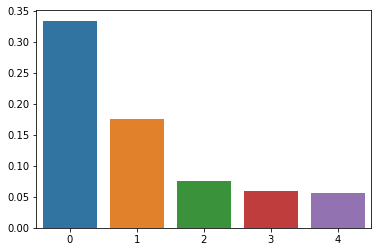

In [25]:
sns.barplot(x=np.arange(pca.n_components), y=pca.explained_variance_ratio_)

This is what it says in the paper

We denote the projection of a vector $ v $ onto $ B $ by

$$ v_B = \sum_{j=1}^{k} (v \cdot b_j) b_j $$

For each word $ w \in N $, let $ \vec{w} $ be re-embedded to
$$ \vec{w} := \vec{w} - \vec{w_{B}} / || \vec{w} - \vec{w_{B}} || $$

$$ \mu := \sum_{w \in E}w / |E| $$
$$ \nu := \mu - \mu_B $$
For each $ w \in E $, 
$$ \vec{w} := \nu + \sqrt{1 - ||\nu||^2}\frac{\vec{w_B} - \mu_B}{||\vec{w_B} - \mu_B||} $$

In [26]:
def remove_subspace(X: np.ndarray, subspace: np.ndarray, norm=True) -> np.ndarray:
    Xb = ((X @ subspace.T) @ subspace) # projection onto biased subspace
    X = (X - Xb) / (np.linalg.norm(X - Xb))
    if norm:
        mu = X.mean(0)
        mub = Xb.mean(0)
        nu = mu - mub
        return nu + np.sqrt(1 - nu**2) * (Xb - mub) / np.linalg.norm(Xb - mub)
    else:
        return X

In [27]:
remove_subspace(male_vecs, pca.components_)

array([[ 0.01650096, -0.1000125 , -0.00558285, ..., -0.03515185,
        -0.1651776 ,  0.01506699],
       [ 0.01348943, -0.10363556, -0.00717191, ..., -0.03128222,
        -0.15948816,  0.02207921],
       [ 0.01125072, -0.10663339, -0.00471461, ..., -0.02876034,
        -0.15997502,  0.02352692],
       ...,
       [ 0.00804645, -0.11074347,  0.0040258 , ..., -0.02450902,
        -0.16264895,  0.0224969 ],
       [ 0.00983971, -0.11074638,  0.00490333, ..., -0.02531959,
        -0.16378503,  0.02271097],
       [ 0.00980121, -0.1096987 ,  0.00346164, ..., -0.02612087,
        -0.16351649,  0.02183877]], dtype=float32)

### Newly checking for differences

In [28]:
def pp(X: np.ndarray) -> np.ndarray:
    """Postprocess"""
    return remove_subspace(np.expand_dims(X, 0), pca.components_, norm=False)[0]

In [29]:
def compute_new_diff_similarity(cwords1, cwords2):
    cword11, cword12 = cwords1
    cword21, cword22 = cwords2
    return cosine_similarity(pp(get_word_vector(cword11)) - pp(get_word_vector(cword12)),
                             pp(get_word_vector(cword21)) - pp(get_word_vector(cword22)))

Similarities are being reduced, so there is a shared gender subspace to a certain extent.

In [30]:
compute_new_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The programmer went to the office.", "programmer"),
     ContextWord("The nurse went to the office.", "nurse"))
)

0.119350664

In [31]:
compute_new_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The doctor went to the office.", "doctor"),
     ContextWord("The nurse went to the office.", "nurse"))
)

0.14438437

In [32]:
compute_new_diff_similarity(
    (ContextWord("he likes sports.", "he"), ContextWord("she likes sports.", "she")),
    (ContextWord("The doctor went to the office.", "doctor"),
     ContextWord("The nurse went to the office.", "nurse"))
)

0.19711463

# Checking for change in bias score

Let's see if the bias score decreases with this transformation

In [33]:
def bias_score(sentence: str, gender_words: Iterable[str], 
               word: str, gender_comes_first=True, 
               correct_bias=True,
               postprocess=False) -> float:    
    mw, fw = gender_words
    mwi, fwi = processor.token_to_index(mw), processor.token_to_index(fw)
    wv = get_word_vector(
        ContextWord(sentence.replace("XXX", word).replace("GGG", "[MASK]"), "[MASK]"),
        use_last_mask=not gender_comes_first,        
    )
    if postprocess: wv = pp(wv)
    logits = to_logits(wv)
    subject_fill_bias = logits[mwi] - logits[fwi]
    if correct_bias:
        wv = get_word_vector(
            ContextWord(sentence.replace("XXX", "[MASK]").replace("GGG", "[MASK]"), "[MASK]"),
            use_last_mask=gender_comes_first,
        )
        if postprocess: wv = pp(wv)
        prior_logits = to_logits(wv)
        prior_bias = prior_logits[mwi] - prior_logits[fwi]
        subject_fill_bias = subject_fill_bias - prior_bias
    return subject_fill_bias

Bias is amplified here

In [34]:
bias_score("GGG is a XXX.", ["he", "she"], "doctor")

0.32679677

In [35]:
bias_score("GGG is a XXX.", ["he", "she"], "doctor", postprocess=True)

0.6350299

Bias is neutralized here

In [36]:
bias_score("GGG is a XXX.", ["he", "she"], "nurse")

-4.859275

In [37]:
bias_score("GGG is a XXX.", ["he", "she"], "nurse", postprocess=True)

-0.26979792

Testing for adjectives

In [38]:
bias_score("GGG is very XXX.", ["he", "she"], "beautiful")

-3.4315097

In [39]:
bias_score("GGG is very XXX.", ["he", "she"], "beautiful", postprocess=True)

-0.42505538

Bias is neutralized despite being biased in male direction before...

In [40]:
bias_score("GGG is very XXX.", ["he", "she"], "dangerous")

0.4758742

In [41]:
bias_score("GGG is very XXX.", ["he", "she"], "dangerous", postprocess=True)

0.2890259

Same again...

In [42]:
bias_score("GGG is very XXX.", ["he", "she"], "cute")

-0.32514405

In [43]:
bias_score("GGG is very XXX.", ["he", "she"], "cute", postprocess=True)

0.19705546

# Unintended Side Effects

Are there any unintended side effects of this transformation? Let's test and see

In [44]:
compute_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The programmer went to the office.", "programmer"),
     ContextWord("The doctor went to the office.", "doctor"))
)

-0.0094642835

In [45]:
 def construct_sim_matrix_df(cws: List[ContextWord]):
    return pd.DataFrame(data=sim, index=words, columns=words)

In [46]:
cws = [
    ContextWord("The programmer went to the office.", "programmer"),
    ContextWord("The doctor went to the office.", "doctor"),
    ContextWord("The nurse went to the office.", "nurse"),
]
sim = construct_sim_matrix([get_word_vector(cw) for cw in cws])
pd.DataFrame(data=sim, index=[cw.word for cw in cws], columns=[cw.word for cw in cws])

,programmer,doctor,nurse
programmer,1.000000,0.683078,0.634901
doctor,0.683078,1.000000,0.835144
nurse,0.634901,0.835144,1.000000


Interestingly, the similarities here seem to be roughly preserved

In [47]:
sim = construct_sim_matrix([pp(get_word_vector(cw)) for cw in cws])
pd.DataFrame(data=sim, index=[cw.word for cw in cws], columns=[cw.word for cw in cws])

,programmer,doctor,nurse
programmer,1.000000,0.681834,0.634544
doctor,0.681834,1.000000,0.836736
nurse,0.634544,0.836736,1.000000


In [48]:
cws = [
    ContextWord("Your colleague is very beautiful.", "beautiful"),
    ContextWord("Your colleague is very dangerous.", "dangerous"),
    ContextWord("Your colleague is very normal.", "normal"),
]
sim = construct_sim_matrix([get_word_vector(cw) for cw in cws])
pd.DataFrame(data=sim, index=[cw.word for cw in cws], columns=[cw.word for cw in cws])

,beautiful,dangerous,normal
beautiful,1.000000,0.600859,0.583575
dangerous,0.600859,1.000000,0.536445
normal,0.583575,0.536445,1.000000


In [49]:
sim = construct_sim_matrix([pp(get_word_vector(cw)) for cw in cws])
pd.DataFrame(data=sim, index=[cw.word for cw in cws], columns=[cw.word for cw in cws])

,beautiful,dangerous,normal
beautiful,1.000000,0.576893,0.570956
dangerous,0.576893,1.000000,0.515323
normal,0.570956,0.515323,1.000000


# Non-linearity of BERT embeddings

BERT embeddings no longer express the same linear semantics as word2vec/GloVe.

In [50]:
compute_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("I am a king.", "king"),
     ContextWord("I am a queen.", "queen"))
)

0.57149196

In [51]:
compute_diff_similarity(
    (ContextWord("he is my friend.", "he"), ContextWord("she is my friend.", "she")),
    (ContextWord("they are the king.", "king"),
     ContextWord("they are the queen.", "queen"))
)

0.4555073

The difference in direction does not stay constant as the subject/object status of the word changes.

In [52]:
compute_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("The king walked across the road.", "king"),
     ContextWord("The queen walked across the road.", "queen"))
)

0.35181317

In [53]:
compute_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("king does not do such things.", "king"),
     ContextWord("queen does not do such things", "queen"))
)

0.24944247

In [54]:
compute_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("I captured the opponent's king.", "king"),
     ContextWord("I captured the opponent's queen.", "queen"))
)

0.40263602

In [55]:
compute_diff_similarity(
    (ContextWord("I am a man.", "man"), ContextWord("I am a woman.", "woman")),
    (ContextWord("king, please forgive me!", "king"),
     ContextWord("queen, please forgive me!", "queen"))
)

0.21260612

In [56]:
compute_diff_similarity(
    (ContextWord("his attitude is irritating.", "his"), 
     ContextWord("her attitude is irritating.", "her")),
    (ContextWord("they are the king.", "king"),
     ContextWord("they are the queen.", "queen"))
)

0.44601032